In [30]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

import os
import random
import pickle
import pandas as pd
from collections import defaultdict

import utility
import functions

## Task 1

#### Settings

In [2]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30

do not run again below this line

In [ ]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

tracks_list = list(enumerate(tracks))

# save tracks_list
open_file = open("tracks_list.pkl", "wb")
pickle.dump(tracks_list, open_file)
open_file.close()

In [4]:
tracks_list[0]

(0, WindowsPath('data/mp3s-32k/aerosmith/Aerosmith/01-Make_It.wav'))

In [ ]:
data_folder = Path("query/")
mp3_tracks = data_folder.glob("*.mp3")
query = data_folder.glob("*.wav")

query_list = list(enumerate(query))

# save query_list
open_file = open("query_list.pkl", "wb")
pickle.dump(query_list, open_file)
open_file.close()

#### Preprocessing

In [ ]:
# convert mp3 to wav
for track in tqdm(mp3_tracks, total=N_TRACKS):
    utility.convert_mp3_to_wav(str(track))

do not run again above this line

#### Audio signals

In [3]:
open_file = open("tracks_list.pkl", "rb")
tracks_list = pickle.load(open_file)
open_file.close()

In [4]:
# list of track title and author
tracks_title = []
for i in range(len(tracks_list)):
    aux = tracks_list[i][1].__str__().replace('_', ' ').replace('.wav', '').split("\\", 4)
    tracks_title.append([aux[-1], aux[2]])
tracks_titles = list(enumerate(tracks_title))

In [5]:
tracks_titles[0]

(0, ['01-Make It', 'aerosmith'])

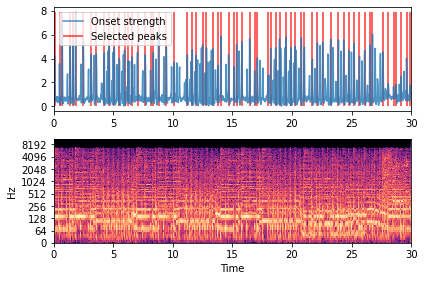

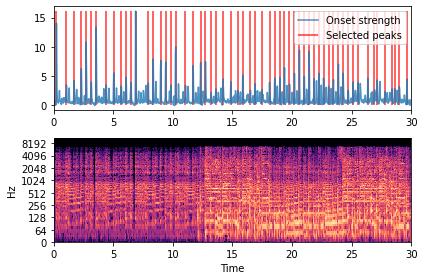

In [6]:
for idx, audio in tracks_list:
    if idx >= 2:
        break
    track, sr, onset_env, peaks = utility.load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    utility.plot_spectrogram_and_peaks(track, sr, peaks, onset_env)

### 1 Minhashing

By using the function <code>functions.zeros_ones_matrix</code> we compute a zeros-ones matrix of  representative of the dataset.
The number of rows corresponds to the maximum possible peak index and each column is representative of a track.
For each track we assign ones-entries to the indexes of peaks (bins where peaks occur). 

In [7]:
m = round(sr*DURATION/HOP_SIZE) # maximum peak index
m

1292

do not run again below this line

In [10]:
# generate and store tracks matrix
tracks_matrix = functions.zeros_ones_matrix(m, 'tracks', tracks_list)

  0%|          | 0/1413 [00:00<?, ?it/s]

do not run again above this line

In [9]:
open_file = open("tracks_matrix.pkl", "rb")
tracks_matrix = pickle.load(open_file)
open_file.close()

tracks_matrix.shape, tracks_matrix.nbytes

((1292, 1413), 1825596)

In [10]:
# pandas visualization of tracks matrix
new_col = [item[1][0].split("-", 1)[1] for item in tracks_titles]
df = pd.DataFrame(tracks_matrix, columns=new_col)
df

,Make It,Somebody,Dream On,One Way Street,Mama Kin,Write Me a Letter,Movin Out,Walking the Dog,Draw the Line,I Wanna Know Why,...,Zooropa,Babyface,Numb,Lemon,Stay Faraway So Close,Daddy s Gonna Pay For Your Crashed Car,Some Days Are Better Than Others,The First Time,Dirty Day,The Wanderer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
1288,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We want to associate each track with a *signature* based on the previously defined representative matrix of the dataset.

In order to do this, first we generate $n_{hash}$ random hash functions from an *universal family of hash functions with a prime field*:

\begin{equation}
H = \{h_{c_0, c_1} | c_0 \in \{1,2,..., p - 1\},  c_1 \in \{1,2,..., p - 1\}\}
\end{equation}

\begin{equation}
h_{c_0, c_1}(x) = ((c_1x + c_0)\mod p)\mod n); x \in U
\end{equation}
- $U : \{0,1,..., m-1\}$
- number $n \le m$
- prime number $p \ge m$

The probability that distinct elements $x_1, x_2 \in U$ collide in $n$ is $P(h(x_1) = h(x_2)) \le \frac{1}{n}$

In [8]:
# hash settings
p = 1789 # prime number
n = 1000
nh = 24 # number of random hash functions

do not run again below this line

In [11]:
# generate random coefficients
c_0 = random.sample(range(0, p - 1), nh)
c_1 = random.sample(range(0, p - 1), nh)

# save coefficients
with open('coefficient.npy', 'wb') as f:
    np.save(f, c_0)
    np.save(f, c_1)

do not run again above this line

In [12]:
with open('coefficient.npy', 'rb') as f:
    c_0 = np.load(f)
    c_1 = np.load(f)

c_0, c_1, [len(set(c_0)), len(set(c_1))]

(array([1576,   17,  372,  516,  208,  297,  307, 1447, 1147,  684, 1078,
         706,  785,  523,  363,  774, 1589,  525, 1212,  539, 1584,  268,
          62,  318]),
 array([ 821, 1457, 1596, 1441, 1051,  889,  611,  204, 1724,  392,  361,
        1412,  560,  194,  394,  869, 1110,  605, 1693, 1389,  590, 1136,
         261, 1190]),
 [24, 24])

For each $k^{th}$ track (column of tracks matrix) we apply the $i^{th}$ *hash function* to each *row-index* with non-zero entry.

The $i^{th}$ component of the signature is equal to the *minimum* among these values.

- $k \in \{1, 2, 3,..., n_{tracks}\}$ where $n_{tracks}$ is the number of tracks in the dataset (variable <code>N_TRACKS</code>)
- $i \in \{1, 2, 3,..., n_{hash}\}$ where $n_{hash}$ is the number of random hash functions generated from the previously defined family (variable <code>nh</code>)

The function <code>functions.minhash</code> performs these operations.

The *signature matrix* - we compute through the function <code>functions.generate_signature</code> - has shape $(n_{hash}, n_{tracks})$.

do not run again below this line

In [14]:
# generate and store signature matrix
signature_matrix = functions.generate_signature(tracks_list, tracks_matrix, 'tracks', nh, c_0, c_1, p, n)

  0%|          | 0/1413 [00:00<?, ?it/s]

do not run again above this line

In [15]:
open_file = open("signature_matrix_tracks.pkl", "rb")
signature_matrix = pickle.load(open_file)
open_file.close()

signature_matrix.shape, signature_matrix.nbytes

((24, 1413), 33912)

In [16]:
# pandas visualization of signature matrix
new_col = [item[1][0].split("-", 1)[1] for item in tracks_titles]
df = pd.DataFrame(signature_matrix, columns=new_col)
df

,Make It,Somebody,Dream On,One Way Street,Mama Kin,Write Me a Letter,Movin Out,Walking the Dog,Draw the Line,I Wanna Know Why,...,Zooropa,Babyface,Numb,Lemon,Stay Faraway So Close,Daddy s Gonna Pay For Your Crashed Car,Some Days Are Better Than Others,The First Time,Dirty Day,The Wanderer
0,33,4,7,20,8,5,6,4,19,1,...,16,8,23,16,11,5,24,1,1,3
1,20,46,7,14,5,9,7,54,8,35,...,45,13,24,1,14,11,1,7,3,7
2,13,19,8,2,19,3,14,2,2,48,...,22,6,6,9,19,38,2,10,18,7
3,10,4,15,4,19,11,5,1,0,8,...,13,5,9,4,18,6,11,4,0,19
4,11,1,4,12,16,45,66,27,1,11,...,2,15,27,2,17,10,14,27,3,6
5,21,6,14,36,6,10,21,53,18,45,...,20,3,7,8,8,17,17,8,30,29
6,9,1,6,3,27,2,7,9,81,9,...,87,14,4,0,11,22,2,17,16,2
7,1,5,0,15,18,0,22,39,25,12,...,34,2,2,1,12,1,28,6,12,17
8,4,14,0,0,0,35,7,68,7,9,...,3,3,9,6,55,57,4,4,9,3
9,7,22,10,10,11,7,10,20,34,10,...,59,12,12,46,41,18,10,6,4,4


Now we're applying the same operations to the queries, stored in the query folder.

In [17]:
open_file = open("query_list.pkl", "rb")
query_list = pickle.load(open_file)
open_file.close()

do not run again below this line

In [18]:
# generate and store query matrix
query_matrix = functions.zeros_ones_matrix(m, 'query', query_list)

  0%|          | 0/10 [00:00<?, ?it/s]

do not run again below this line

In [19]:
# generate and store signature query
signature_query = functions.generate_signature(query_list, query_matrix, "query", nh, c_0, c_1, p, n)

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
open_file = open("query_matrix.pkl", "rb")
query_matrix = pickle.load(open_file)
open_file.close()
query_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int8)

In [20]:
open_file = open("signature_matrix_query.pkl", "rb")
signature_query = pickle.load(open_file)
open_file.close()
signature_query

array([[  7,  11,  61,  13,  27,  33,  16,   3,  41,  20],
       [  7,   8,   1,   3,  28,   1,   1,   7,  10,  30],
       [  8,  26,  29,  18,   3,   2,   3,   0,   6,   2],
       [ 15,   0,   5,   4,   0,  13,  25,   1,  14,  47],
       [  4,   3,   2,  26,  42,   0,   0,   2,  33,   0],
       [ 14,  10,  47,   7,  26,   4,   8,  13,  51,   0],
       [  6,  14,   7,   1,   9,  12,   9,   1,   6,  12],
       [  0,   6,  11,  13,   6,   0,  14,  11,   1,   3],
       [  0,   6,   9,   0,  26,  15,   3,  17,   9,   4],
       [ 10,   4, 101,   1,  19,   1,  56,   9,  21,   6],
       [  5,   8,  20,   6,   2,   0,  16,  33,  43,  10],
       [ 11,  11,  54,   9,   6,   7,  30,   9, -99,  27],
       [ 36,   5,  13,   2,   1,  31,   3,   1, -71,   1],
       [ 10,   6,  32,   3,  31,   3,   3,  33,  10,   2],
       [  1,   9,  82,   5,   6,  22,   6,  11,  16,  17],
       [ 16,   0,   1,   2,  33,   6,   6,   0,  28,  29],
       [  3,   5,  85,   5,  18,   8,   4,  35,  39,   0

### 1 LSH matching

We look for possible matches with queries by performing Locality Sensitive Hashing.
Steps we made:
- split the signature matrix and the query matrix into equidimensional bands;
- generate hash function of random coefficients for each band;
- hash each split-signature belonging to a specific band to a bucket;
- a dictionary for each band maps bucket to track index;
- a dictionary (print of the following functions) maps query to a list of sets (one for each band) of candidates, track indexes that share the bucket with the query for that band;
- final candidates are those that share at least one bucket with the query;
- evaluate Jaccard similarity.

In [31]:
bands = [4, 6, 8]

In [32]:
# generate directories
for i in bands:
    path = f'{i}_bands'
    os.makedirs(path)

#### bands = 4

In [39]:
candidates_4 = functions.lsh(bands[0], signature_query, signature_matrix)

defaultdict(None, {0: [{2}, {2, 770}, {1210, 2, 394}, {2, 42}], 1: [{976}, {976}, {976}, {976, 310}], 2: [{1367}, {1056, 779, 332, 822, 1367}, {1367}, {1367}], 3: [{125}, {125, 1151}, {125, 510, 79}, {125, 1351}], 4: [{624, 1024, 1362, 1318}, {1024, 629, 543}, {1024}, {1024}], 5: [{837, 669, 1109}, {1332, 669, 287}, {914, 669}, {752, 650, 669}], 6: [{456}, {456, 1295}, {456, 1072}, {456, 1043}], 7: [{561, 1409}, {561}, {561, 572, 61, 390}, {561}], 8: [{396, 533}, {488, 396}, {396}, {793, 396}], 9: [{1166}, {1166}, {1166, 382, 895}, {1313, 1166}]})


In [40]:
candidates_4

[[2, 770, 42, 1210, 394],
 [976, 310],
 [1056, 822, 1367, 779, 332],
 [79, 1351, 125, 510, 1151],
 [624, 1024, 1362, 629, 1318, 543],
 [837, 650, 752, 914, 1332, 1109, 669, 287],
 [1072, 1043, 456, 1295],
 [561, 1409, 390, 572, 61],
 [533, 488, 793, 396],
 [1313, 1166, 382, 895]]

In [45]:
# threshold = 0.2
functions.find_matches(signature_matrix, signature_query, cand, tracks_titles, 0.2)

The 1st track you are looking for could be Dream On, sung by Aerosmith. Jaccard similarity is equal to 1.0.

The 2nd track you are looking for could be Penny Lane, sung by Beatles. Jaccard similarity is equal to 0.2.

The 2nd track you are looking for could be I Want To Break Free, sung by Queen. Jaccard similarity is equal to 1.0.

The 2nd track you are looking for could be Shout, sung by Depeche Mode. Jaccard similarity is equal to 0.3.

The 3th track you are looking for could be Everybody s Trying To Be My Baby, sung by Beatles. Jaccard similarity is equal to 0.2.

The 3th track you are looking for could be October, sung by U2. Jaccard similarity is equal to 1.0.

The 4th track you are looking for could be Ob-La-Di Ob-La-Da, sung by Beatles. Jaccard similarity is equal to 1.0.

The 5th track you are looking for could be Karma Police, sung by Radiohead. Jaccard similarity is equal to 1.0.

The 6th track you are looking for could be Heartbreaker, sung by Led Zeppelin. Jaccard similari

[[[2, 1.0]],
 [[105, 0.2], [976, 1.0], [413, 0.3]],
 [[96, 0.2], [1367, 1.0]],
 [[125, 1.0]],
 [[1024, 1.0]],
 [[669, 1.0], [821, 0.2]],
 [[456, 1.0], [969, 0.2]],
 [[561, 1.0]],
 [[396, 1.0]],
 [[1166, 1.0]]]

In [46]:
# threshold = 0.3
functions.find_matches(signature_matrix, signature_query, cand, tracks_titles, 0.3)

The 1st track you are looking for could be Dream On, sung by Aerosmith. Jaccard similarity is equal to 1.0.

The 2nd track you are looking for could be I Want To Break Free, sung by Queen. Jaccard similarity is equal to 1.0.

The 3th track you are looking for could be October, sung by U2. Jaccard similarity is equal to 1.0.

The 4th track you are looking for could be Ob-La-Di Ob-La-Da, sung by Beatles. Jaccard similarity is equal to 1.0.

The 5th track you are looking for could be Karma Police, sung by Radiohead. Jaccard similarity is equal to 1.0.

The 6th track you are looking for could be Heartbreaker, sung by Led Zeppelin. Jaccard similarity is equal to 1.0.

The 7th track you are looking for could be Go Your Own Way, sung by Fleetwood Mac. Jaccard similarity is equal to 1.0.

The 8th track you are looking for could be American Idiot, sung by Green Day. Jaccard similarity is equal to 1.0.

The 9th track you are looking for could be Somebody, sung by Depeche Mode. Jaccard similarity

[[[2, 1.0]],
 [[976, 1.0]],
 [[1367, 1.0]],
 [[125, 1.0]],
 [[1024, 1.0]],
 [[669, 1.0]],
 [[456, 1.0]],
 [[561, 1.0]],
 [[396, 1.0]],
 [[1166, 1.0]]]

#### bands = 6 

In [41]:
candidates_6 = functions.lsh(bands[1], signature_query, signature_matrix)

defaultdict(None, {0: [{2}, {2, 659}, {1088, 2}, {2}, {2, 282, 1340}, {2}], 1: [{72, 771, 976}, {976}, {976, 1257, 527}, {664, 556, 976}, {976, 212}, {976, 1088, 182}], 2: [{1367}, {1367}, {203, 1367}, {112, 1367}, {726, 1367}, {1367}], 3: [{9, 125}, {125}, {125, 661}, {125}, {762, 125}, {125}], 4: [{1024, 137, 425}, {16, 1024}, {1024, 430, 1240}, {224, 33, 1024, 790, 1183}, {1024, 146}, {1024, 1359}], 5: [{669, 1118}, {669}, {1083, 669}, {841, 236, 669}, {669, 182, 375}, {669}], 6: [{456, 1248}, {456}, {456}, {456, 305}, {456}, {456, 641}], 7: [{561, 170}, {561, 691}, {561}, {561}, {561}, {561}], 8: [{396, 276}, {666, 523, 396, 45}, {396}, {396}, {416, 932, 396}, {396}], 9: [{1166}, {221, 1166, 847}, {429, 1166}, {1166}, {1085, 725, 1166}, {763, 1166}]})


In [42]:
candidates_6

[[1088, 2, 659, 282, 1340],
 [1088, 771, 72, 1257, 556, 527, 976, 212, 182, 664],
 [112, 726, 1367, 203],
 [661, 9, 762, 125],
 [1024, 224, 33, 137, 425, 430, 1359, 16, 146, 790, 1240, 1183],
 [182, 375, 841, 1083, 236, 669, 1118],
 [1248, 305, 641, 456],
 [561, 170, 691],
 [416, 276, 932, 666, 523, 396, 45],
 [1085, 725, 763, 429, 221, 1166, 847]]

#### bands = 8

In [43]:
candidates_8 = functions.lsh(bands[2], signature_query, signature_matrix)

defaultdict(None, {0: [{2}, {2}, {2, 1391, 853, 410}, {2, 199}, {2}, {2, 118}, {2}, {2}], 1: [{976, 1153}, {976}, {976, 105, 413}, {976, 357, 975}, {976, 482}, {976}, {976}, {976}], 2: [{674, 1367}, {547, 1367}, {640, 109, 1367}, {1367}, {541, 1367, 671}, {1367}, {1367}, {96, 751, 1271, 253, 1367}], 3: [{125}, {125}, {508, 125, 1078}, {41, 125}, {125}, {125}, {955, 988, 125}, {125}], 4: [{1024, 1001}, {1024}, {1024, 1256, 427, 1005, 1328, 786, 764}, {1024, 1208}, {1024}, {1024, 1073}, {1024}, {1024}], 5: [{669}, {572, 669, 534}, {669}, {669}, {724, 669}, {821, 669, 926}, {628, 669}, {669}], 6: [{456, 914}, {456, 140, 492, 1261, 633, 470, 409, 1083}, {456, 969}, {456}, {456, 292}, {456, 457}, {456}, {456}], 7: [{561}, {472, 561}, {561}, {561}, {385, 666, 561}, {561, 477}, {561}, {561, 811, 1053}], 8: [{396}, {396}, {396, 492, 422}, {396}, {33, 396}, {396}, {396}, {396}], 9: [{1166}, {1166}, {149, 1166}, {435, 1166, 1019}, {209, 1166}, {1166}, {1166}, {1166, 685, 1158}]})


In [44]:
candidates_8

[[2, 853, 118, 199, 410, 1391],
 [976, 1153, 482, 357, 105, 413, 975],
 [640, 96, 674, 547, 109, 751, 1367, 253, 1271, 541, 671],
 [1078, 988, 41, 955, 508, 125],
 [1024, 1256, 1001, 427, 1005, 1328, 1073, 786, 1208, 764],
 [724, 821, 534, 628, 572, 669, 926],
 [292, 456, 969, 409, 457, 140, 492, 1261, 914, 470, 633, 1083],
 [561, 385, 1053, 472, 666, 811, 477],
 [33, 422, 396, 492],
 [209, 435, 149, 1158, 1019, 685, 1166]]

#### Masking matching

We check the results by performing for each signature query a boolean comparison with all the signatures (not only with the candidates).

In [21]:
threshold_0 = 0.5
matches_0 = functions.find_similarities(signature_matrix, signature_query, tracks_titles, threshold_0)

The 1st track you are looking for could be Dream On, sung by Aerosmith. Jaccard similarity is equal to 1.0.

The 2nd track you are looking for could be I Want To Break Free, sung by Queen. Jaccard similarity is equal to 1.0.

The 3th track you are looking for could be October, sung by U2. Jaccard similarity is equal to 1.0.

The 4th track you are looking for could be Ob-La-Di Ob-La-Da, sung by Beatles. Jaccard similarity is equal to 1.0.

The 5th track you are looking for could be Karma Police, sung by Radiohead. Jaccard similarity is equal to 1.0.

The 6th track you are looking for could be Heartbreaker, sung by Led Zeppelin. Jaccard similarity is equal to 1.0.

The 7th track you are looking for could be Go Your Own Way, sung by Fleetwood Mac. Jaccard similarity is equal to 1.0.

The 8th track you are looking for could be American Idiot, sung by Green Day. Jaccard similarity is equal to 1.0.

The 9th track you are looking for could be Somebody, sung by Depeche Mode. Jaccard similarity

In [22]:
threshold_1 = 0.25
matches_1 = functions.find_similarities(signature_matrix, signature_query, tracks_titles, threshold_1)

The 1st track you are looking for could be Dream On, sung by Aerosmith. Jaccard similarity is equal to 1.0.

The 1st track you are looking for could be Kyoto Song, sung by Cure. Jaccard similarity is equal to 0.4.

The 1st track you are looking for could be Cry Freedom, sung by Dave Matthews Band. Jaccard similarity is equal to 0.3.

The 2nd track you are looking for could be Shout, sung by Depeche Mode. Jaccard similarity is equal to 0.3.

The 2nd track you are looking for could be I Want To Break Free, sung by Queen. Jaccard similarity is equal to 1.0.

The 3th track you are looking for could be October, sung by U2. Jaccard similarity is equal to 1.0.

The 4th track you are looking for could be Ob-La-Di Ob-La-Da, sung by Beatles. Jaccard similarity is equal to 1.0.

The 4th track you are looking for could be Sail Away Sweet Sister, sung by Queen. Jaccard similarity is equal to 0.3.

The 5th track you are looking for could be Karma Police, sung by Radiohead. Jaccard similarity is equa

In [23]:
matches_1

[[[2, 1.0], [224, 0.4], [302, 0.3]],
 [[413, 0.3], [976, 1.0]],
 [[1367, 1.0]],
 [[125, 1.0], [967, 0.3]],
 [[1024, 1.0]],
 [[171, 0.3], [669, 1.0]],
 [[456, 1.0], [928, 0.3]],
 [[561, 1.0]],
 [[396, 1.0]],
 [[787, 0.3], [1166, 1.0]]]

## Q2.1
On this first part we are collecting the data and merge them in a single pandas file. The merge is process on the track_id

In [1]:
import os
import fun
import pandas as pd
import warnings
import numpy as np
from ex2function import kmean
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [3]:
# it check if the data are download if not it download it
dir = 'data/csv/'
files = os.listdir(dir)
if (len(files) < 3) :
    #download the data if there is not the csv
    fun.downloadcsv()
files.remove("tr.txt")
#load the differente csv file into pd
df1 = pd.read_csv(dir+files[0])
df2 = pd.read_csv(dir+files[1])
df3 = pd.read_csv(dir+files[2])


In [4]:
#merge the data
dataset = pd.merge(df1, df2, on='track_id', how='inner')
dataset = pd.merge(dataset, df3, on='track_id', how='inner')
print(dataset.shape, df1.shape, df2.shape, df3.shape)

(13129, 820) (13129, 250) (106574, 519) (106574, 53)


## Q2.2
On this part we are will aplly a dimential reduction on the continuous variable we will use Principal Component Analysis. However in a first time we will transform the non numerical variaibles into discret numerical varaible Note that we won't apply the dimential reduction to this row

In [4]:
# transform non numerical variaibles
le = preprocessing.LabelEncoder()
dataset_all = dataset.copy()
for n in dataset_all.columns.values:
    #columns with non-numeric values
    if dataset_all[n].dtype == object :
        #replace missing values by 'None'
        dataset_all[n].fillna("None", inplace = True)
        le = preprocessing.LabelEncoder()
        dataset_all[n]= le.fit_transform(dataset_all[n])
    elif dataset_all[n].dtype == float :
        #replace missing values by 0.
        dataset_all[n].fillna(0., inplace = True)
    elif dataset_all[n].dtype == int:
        #replace missing values by 0
        dataset_all[n].fillna(0, inplace = True)
#take the row that are only numérical
dataset_Num = dataset[dataset.T[dataset.dtypes!=np.object].index]

On the following method we decide how many compenent are been keep in orther to keep > 70% of the total variance. this is done via a brute force algorithm 

In [5]:
def reduc07(dataset):
    for n in range(len(dataset)):
        pca = PCA(n_components=n)
        x = StandardScaler().fit_transform(dataset[dataset.columns.values])
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        if sum(pca.explained_variance_ratio_) < .7:
            continue
        return principalDf

In [6]:
# find .7 without the discret value
principalDf = reduc07(dataset_all[dataset_Num.columns.values[1:]])
track_id = dataset_all["track_id"]
print(len(principalDf))



13129


In [7]:
#merge the discret value with the coninuous value
dataset_all.drop(dataset_Num.columns.values, axis = 1, inplace = True)
x = StandardScaler().fit_transform(dataset_all[dataset_all.columns.values])
principalDf = pd.DataFrame(data = x)
dataset_all = pd.merge(dataset_all, principalDf, left_index=True, right_index=True)
dataset_all["track_id"] = track_id
# Note that every time that we will use k mean we will remove the track_id


## Q2.3
On this task we were ask to implement our K-means this as been done into the class kmean who is in the file function.py

Following this transformation of the data we are trying to find the optimal number of cluster On this purpose we will use two different method in the first place we will use the Elbow Method. In a segond time we wil use the Silhouette analysis.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


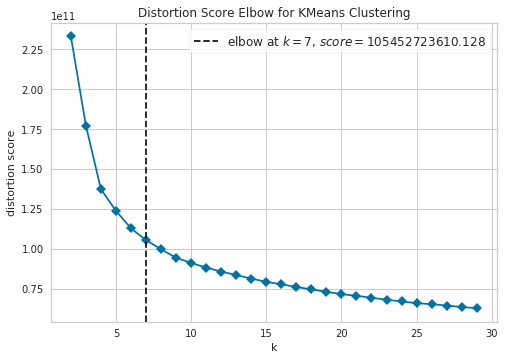

according to the Elbow Method the otimal number of k is 7


In [8]:
# find the number of cluster with Elbow Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), metric='distortion', timings=False)
visualizer.fit(dataset_all[dataset_all.columns.values[:-1]])
visualizer.show()
print("according to the Elbow Method the otimal number of k is",visualizer.elbow_value_)

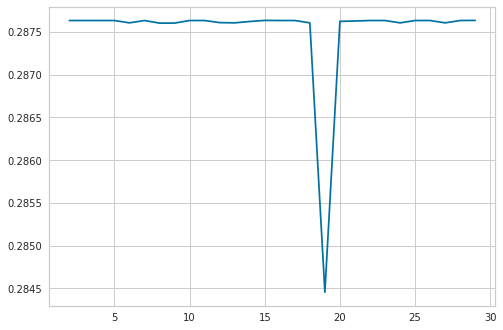

In [9]:
range_n_clusters = [i for i in range(2,30)]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=3)
 kmeans.fit(dataset_all[dataset_all.columns.values[:-1]])
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(dataset_all[dataset_all.columns.values[:-1]], cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.show()

The conclution of this two different analysis is difficult to do the Elbow Method seems two indicated a k at 7. However, the silhouette analysis indicate that the number of cluster does not have an important impact on the result. This would mean that depending on our purpose we could select the number of cluster. However, it could also mean that the k-mean aproach does not suits this dataset <br /> <br />
On the next point we will perform the k-means the we implement ad compare it to the Kmeans++ of sklearn we will take K as 7

In [25]:
k = 7

# our method
km = kmean(dataset_all[dataset_all.columns.values[:-1]])
cluster1 = km.fit(k)

# kmean ++
ourmodel = KMeans(n_clusters=k)
ourmodel.fit(dataset_all[dataset_all.columns.values[:-1]])
cluster2 = ourmodel.predict(dataset_all[dataset_all.columns.values[:-1]])


Now that we have our cluster find by two different method we will try to see if they are similar the following code will take each cluster of our kmeans and see with which cluster of kmeans++ is the most similar

In [26]:
onehot_encoder = OneHotEncoder(sparse=False)
c1 = onehot_encoder.fit_transform(cluster1.reshape(-1,1))
c2 = onehot_encoder.fit_transform(cluster2.reshape(-1,1))
for i in range(k):
    y_one = c1[:,i]
    max = -1
    m = [0, 0]
    for y in range(k):
        y_two = c2[:,y]
        ac = np.round(accuracy_score(y_one, y_two),3)
        if ac > max:
            max = ac
            m = [i, y]
    print('cluster',m[0],'map to cluster',m[1],'with an accuracy of',max)


cluster 0 map to cluster 6 with an accuracy of 0.997
cluster 1 map to cluster 3 with an accuracy of 0.996
cluster 2 map to cluster 1 with an accuracy of 0.999
cluster 3 map to cluster 2 with an accuracy of 0.999
cluster 4 map to cluster 5 with an accuracy of 0.999
cluster 5 map to cluster 4 with an accuracy of 0.998
cluster 6 map to cluster 0 with an accuracy of 0.994


As we could observe all the cluster have find an equivalent cluster in the other k-mean even if they are never exactly the same. It should be expected as we work with a large number of k

## Q2.4
During this last part we will apply the k-mean on the dataset and put the result in corelation with some variable.<br />
On a first time we will create tables were the different cluster are visible with the variaibles <br />
It is important to know that we take the same amount of point for all the data this as the purpose to make the data clear. Furthermore, we select only 7 feature (the same amount as k) for each variaibles

In [27]:
#The 5 varaible 
v1 = "artist_location"
v2 = "track_genre_top"
v3 = "track_language_code"
v4 = "album_type"
v5 = "track_publisher"
variaibles = [v1, v2, v3, v4, v5]

In [34]:
# creation of the pivot table + Calculation of the percentage
pivot = list()
for v in variaibles:
    value = dataset[v].value_counts()[:k].index.values
    df = pd.DataFrame()
    value = np.append(value, 'total')
    df[v] = value
    df.set_index(v, inplace= True)
    ba = min(dataset[v].value_counts()[:k][-1],100)
    for i in range(k):
        df[i] = 0
    for v1 in value:
        ids = dataset[dataset[v] == v1]['track_id'].values
        va = list()
        bal = 0
        for id in ids:
            cu = km.predic(dataset_all[dataset_all['track_id'] == id][dataset_all.columns.values[:-1]])
            df.loc[v1,cu[0]] += 1
            if bal > ba:
                break
            bal += 1 
    for i in range(k):
        df[i] = round((df[i]/df[i].sum())*100, 3)
        df.loc['total',i] += df[i].sum()
    pivot.append(df)

## Analysis
Important some data on the following chart as mark as NaN this mean that no value have been assigne for this cluster

In [35]:
pivot[0]

,0,1,2,3,4,5,6
artist_location,,,,,,,
"Brooklyn, NY",0.0,15.566,0.0,0.0,NaN,16.972,13.502
"New York, NY",0.0,14.151,0.0,0.0,NaN,15.596,16.034
"San Francisco, CA",0.0,15.566,0.0,0.0,NaN,11.009,18.987
"Chicago, IL",0.0,12.736,0.0,0.0,NaN,12.385,20.253
Italy,100.0,11.321,100.0,100.0,NaN,12.385,1.688
"Baltimore, MD",0.0,16.509,0.0,0.0,NaN,18.349,11.392
"Providence, RI",0.0,14.151,0.0,0.0,NaN,13.303,18.143
total,100.0,100.000,100.0,100.0,NaN,99.999,99.999


As we could see on this table the K-means as perfectly identify the cluster (0, 2, 3) as part of Italy for the rest of the data there is no outstanding identification

In [36]:
pivot[1]

,0,1,2,3,4,5,6
track_genre_top,,,,,,,
Rock,0.000,11.923,NaN,NaN,NaN,17.062,15.556
Electronic,0.000,14.231,NaN,NaN,NaN,14.692,15.111
Hip-Hop,0.000,13.077,NaN,NaN,NaN,17.062,14.222
Folk,0.000,12.692,NaN,NaN,NaN,13.270,18.222
Old-Time / Historic,83.333,13.462,NaN,NaN,NaN,10.900,12.889
Pop,0.000,14.615,NaN,NaN,NaN,13.744,15.556
Classical,16.667,20.000,NaN,NaN,NaN,13.270,8.444
total,100.000,100.000,NaN,NaN,NaN,100.000,100.000


As we see on this data Old-Time/Historic track genre as been identify and assign to the cluster 0. An important aspect to consider is that none of the genre as been put in the cluster 2, 3, 4. this could indicated that the k 2, 3 and 4 are farways from the parameters who as an impact on the genre it could be interesting to do further investigation to determine which parameters have an significant impact on the genre. (Question 2.4.6)

In [37]:
pivot[2]

,0,1,2,3,4,5,6
track_language_code,,,,,,,
en,0.000,15.0,0.0,0.0,0.0,11.111,31.818
es,0.000,15.0,0.0,0.0,0.0,14.815,27.273
pt,44.444,0.0,75.0,0.0,0.0,14.815,9.091
tr,0.000,20.0,0.0,0.0,0.0,18.519,18.182
fr,22.222,35.0,25.0,0.0,20.0,3.704,4.545
it,33.333,15.0,0.0,0.0,0.0,18.519,9.091
ru,0.000,0.0,0.0,100.0,80.0,18.519,0.000
total,99.999,100.0,100.0,100.0,100.0,100.002,100.000


This result are more interessting as more cluster have been identify we cloud first say that the pt language as most likely been identify in the cluster 2 (Note that the cluster 0 cloud also been an option) but the most standing result come from the ru who as been identify in the cluster 3 and mostlikely in cluster 4

In [38]:
pivot[3]

,0,1,2,3,4,5,6
album_type,,,,,,,
Album,0.0,35.714,0.0,0.0,0.0,17.647,24.242
Radio Program,0.0,21.429,0.0,0.0,0.0,29.412,24.242
Live Performance,0.0,21.429,0.0,0.0,0.0,41.176,18.182
Single Tracks,0.0,21.429,0.0,0.0,0.0,11.765,33.333
Contest,100.0,0.000,100.0,100.0,100.0,0.000,0.000
total,100.0,100.001,100.0,100.0,100.0,100.000,99.999


As we cloud see the contest seems to belong to the cluster 0, 2, 3 and 4. On of that top we cloud see that the live Performance seems to be identify in cluster 5.

In [39]:
pivot[4]

,0,1,2,3,4,5,6
track_publisher,,,,,,,
Victrola Dog (ASCAP),0.0,0.0,100.0,25.0,57.143,0.000,0.000
Cherry Red Music (UK),0.0,0.0,0.0,0.0,0.000,54.545,0.000
Edison,50.0,40.0,0.0,0.0,0.000,9.091,0.000
WFMU,0.0,20.0,0.0,0.0,0.000,0.000,83.333
Allister Thompson,0.0,0.0,0.0,75.0,42.857,0.000,0.000
Maximum R&amp;D (ASCAP),50.0,20.0,0.0,0.0,0.000,18.182,0.000
"Zen Schlubbo Music, BMI",0.0,20.0,0.0,0.0,0.000,18.182,16.667
total,100.0,100.0,100.0,100.0,100.000,100.000,100.000


from this chart we cloud say that WFMU seems to belong to cluster 6, Allister Thompson to cluster 3, Cherry Red Music (UK) to cluster 5. <br />
<br />
During this analysis of the chart different correlation as been identify this does not mean that there is causation

## Q2.4.7
In a first time we wil genereate all the data

In [40]:
#merge the data
dataset = df2
dataset = pd.merge(dataset, df3, on='track_id', how='inner')


# transform non numerical variaibles
le = preprocessing.LabelEncoder()
dataset_all = dataset.copy()
for n in dataset_all.columns.values:
    #columns with non-numeric values
    if dataset_all[n].dtype == object :
        #replace missing values by 'None'
        dataset_all[n].fillna("None", inplace = True)
        le = preprocessing.LabelEncoder()
        dataset_all[n]= le.fit_transform(dataset_all[n])
    elif dataset_all[n].dtype == float :
        #replace missing values by 0.
        dataset_all[n].fillna(0., inplace = True)
    elif dataset_all[n].dtype == int:
        #replace missing values by 0
        dataset_all[n].fillna(0, inplace = True)
#take the row that are only numérical
dataset_Num = dataset[dataset.T[dataset.dtypes!=np.object].index]

# find .7 without the discret value
principalDf = reduc07(dataset_all[dataset_Num.columns.values[1:]])
track_id = dataset_all["track_id"]
print(len(principalDf))

#merge the discret value with the coninuous value
dataset_all.drop(dataset_Num.columns.values, axis = 1, inplace = True)
x = StandardScaler().fit_transform(dataset_all[dataset_all.columns.values])
principalDf = pd.DataFrame(data = x)
dataset_all = pd.merge(dataset_all, principalDf, left_index=True, right_index=True)
dataset_all["track_id"] = track_id
# Note that every time that we will use k mean we will remove the track_id


106574


In [44]:
#KMeans++
ourmodel = KMeans(n_clusters=k)
ourmodel.fit(dataset_all[dataset_all.columns.values[:-1]])

# creation of the pivot table + Calculation of the percentage
pivot = list()
for v in variaibles:
    value = dataset[v].value_counts()[:k].index.values
    df = pd.DataFrame()
    value = np.append(value, 'total')
    df[v] = value
    df.set_index(v, inplace= True)
    ba = min(dataset[v].value_counts()[:k][-1],100)
    for i in range(k):
        df[i] = 0
    for v1 in value:
        ids = dataset[dataset[v] == v1]['track_id'].values
        va = list()
        bal = 0
        for id in ids:
            cu = ourmodel.predict(dataset_all[dataset_all['track_id'] == id][dataset_all.columns.values[:-1]])
            df.loc[v1,cu[0]] += 1
            if bal > ba:
                break
            bal += 1 
    for i in range(k):
        df[i] = round((df[i]/df[i].sum())*100, 3)
        df.loc['total',i] += df[i].sum()
    pivot.append(df)

In [45]:
pivot[0]

,0,1,2,3,4,5,6
artist_location,,,,,,,
"Brooklyn, NY",0.0,18.713,16.477,15.356,0.0,0.0,0.0
France,0.0,12.865,23.864,14.232,0.0,0.0,0.0
"New York, NY",0.0,14.620,17.045,17.603,0.0,0.0,0.0
"Chicago, IL",0.0,14.035,14.773,19.476,0.0,0.0,0.0
"Perm, Russia",100.0,1.170,0.000,0.000,100.0,100.0,100.0
"Portland, OR",0.0,15.205,15.341,18.352,0.0,0.0,0.0
Italy,0.0,23.392,12.500,14.981,0.0,0.0,0.0
total,100.0,100.000,100.000,100.000,100.0,100.0,100.0


As we cloud observe there is a difference in comparaison with our previous result we don't have the italy who is clearly identify but Perm, Russia

In [46]:
pivot[1]

,0,1,2,3,4,5,6
track_genre_top,,,,,,,
Rock,NaN,15.084,14.163,13.907,NaN,NaN,NaN
Experimental,NaN,15.084,21.888,7.947,NaN,NaN,NaN
Electronic,NaN,15.084,9.442,17.550,NaN,NaN,NaN
Hip-Hop,NaN,15.084,14.163,13.907,NaN,NaN,NaN
Folk,NaN,13.966,12.876,15.563,NaN,NaN,NaN
Pop,NaN,11.173,12.876,17.219,NaN,NaN,NaN
Instrumental,NaN,14.525,14.592,13.907,NaN,NaN,NaN
total,NaN,100.000,100.000,100.000,NaN,NaN,NaN


There is also significant change on this table as there is no clear cluster anymore

In [47]:
pivot[2]

,0,1,2,3,4,5,6
track_language_code,,,,,,,
en,0.000,8.163,24.390,21.333,0.000,0.0,NaN
es,0.000,26.531,9.756,17.333,0.000,0.0,NaN
fr,0.000,8.163,29.268,18.667,0.000,0.0,NaN
pt,0.000,32.653,2.439,17.333,0.000,0.0,NaN
de,20.833,0.000,7.317,8.000,86.667,75.0,NaN
ru,50.000,12.245,9.756,6.667,13.333,25.0,NaN
it,29.167,12.245,17.073,10.667,0.000,0.0,NaN
total,100.000,100.000,99.999,100.000,100.000,100.0,NaN


The change as also append on this chart as the only language who is clearly identify is de

In [48]:
pivot[3]

,0,1,2,3,4,5,6
album_type,,,,,,,
Album,NaN,22.222,25.926,16.667,NaN,NaN,NaN
Radio Program,NaN,44.444,7.407,23.810,NaN,NaN,NaN
Live Performance,NaN,0.000,51.852,4.762,NaN,NaN,NaN
Single Tracks,NaN,22.222,7.407,28.571,NaN,NaN,NaN
Contest,NaN,11.111,7.407,26.190,NaN,NaN,NaN
total,NaN,99.999,99.999,100.000,NaN,NaN,NaN


As on the previous chart there are some change. However, we are able to refind a cluster that we had previously Live performance seem to be identify in cluster 2

In [49]:
pivot[4]

,0,1,2,3,4,5,6
track_publisher,,,,,,,
Victrola Dog (ASCAP),24.324,27.273,0.000,0.000,0.0,18.182,0.0
You've Been a Wonderful Laugh Track (ASCAP),31.081,4.545,12.121,19.231,0.0,0.000,0.0
Section 27,8.108,22.727,30.303,30.769,0.0,0.000,0.0
www.headphonica.com,0.000,22.727,33.333,50.000,0.0,0.000,0.0
Studio 11,17.568,0.000,0.000,0.000,45.0,54.545,0.0
Mitoma Industries,18.919,22.727,24.242,0.000,0.0,0.000,0.0
Toucan Music,0.000,0.000,0.000,0.000,55.0,27.273,100.0
total,100.000,99.999,99.999,100.000,100.0,100.000,100.0


This chart is the one who as change the most in our previous version we had 3 clear cluster. Now we cloud sat that Toucan Music seems to be in cluster 4 but with less confidence as previously 

 If you could choose, would you rather collect more observations (with fewer features) or fewer observations (with more features) based on the previous analyses? <br />
 I will collect more data having a large data set will be more challeging. As we will mostlikely have to clean the data. However, such a dataset will allow us to explore more possibilies. In the same times these kind of dataset will reduce problems such as overfitting. In global a small data set is always more easy to use but a large dataset if properly clean and explore will be more generale and will have more valuable observation.

## Task 3

In [ ]:
##NAIVE SOLUTION: naive approach to this problem would be to loop through each number and then loop again through the array
# looking for a pair that sums to S.The running time for the below solution would be O(n2)
# because in the worst case we are looping through the array twice to find a pair.

##FASTER SOLUTION: We can write a faster algorithm that will find pairs that sum to S in linear time.
#The algorithm makes a dictionary

import time
import itertools

In [ ]:
# Getting the inputs from the user
my_list = []
target_sum = int(input('Please enter the summation target: '))
list_len = int(input('Enter the length of the desired list of integers: '))
print('Please enter the desired list of integers: ')
for inp in range(list_len):
    my_list.append(int(input('')))

unique_list = set(my_list)
# For measuring the run-time
# start_time = time.time()

# Iterating between the elements of the list and calculating the sum of each pair
for n in itertools.combinations(unique_list, 2):
    if n[0] + n[1] == target_sum:
        print ([n[0], n[1]])

# Uncomment to print out the run-time
# print(f"Running time is: {time.time() - start_time}")

In [ ]:
# Now solving the problem with O(n) time complexity
unique_list = list(unique_list)
my_dict = {}

# Uncomment for measuring the run-time
# start_time = time.time()
for i in unique_list:
    if i in my_dict.keys():
        print (f"({i}, {my_dict[i]})")
    key = target_sum - i
    my_dict[key] = i

# Uncomment to print out the run-time
# print(f"Running time is: {time.time() - start_time}")